IPアドレスと緯度経度が 'latlng_output.csv' に保存されました。
ConvexHull could not be calculated for label 3: QH6421 qhull internal error (qh_maxsimplex): qh.MAXwidth required for qh_maxsimplex.  Used to estimate determinate

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 503699419  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  0  Error-roundoff 5.2e-14  _one-merge 2.6e-13
  _near-inside 1.3e-12  Visible-distance 1e-13  U-max-coplanar 1e-13
  Width-outside 2.1e-13  _wide-facet 6.2e-13  _maxoutside 3.1e-13

A Qhull internal error has occurred.  Please send the input and output to
qhull_bug@qhull.org. If you can duplicate the error with logging ('T4z'), please
include the log file.

ConvexHull could not be calculated for label 6: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 503699419  incidence  Qtriangula

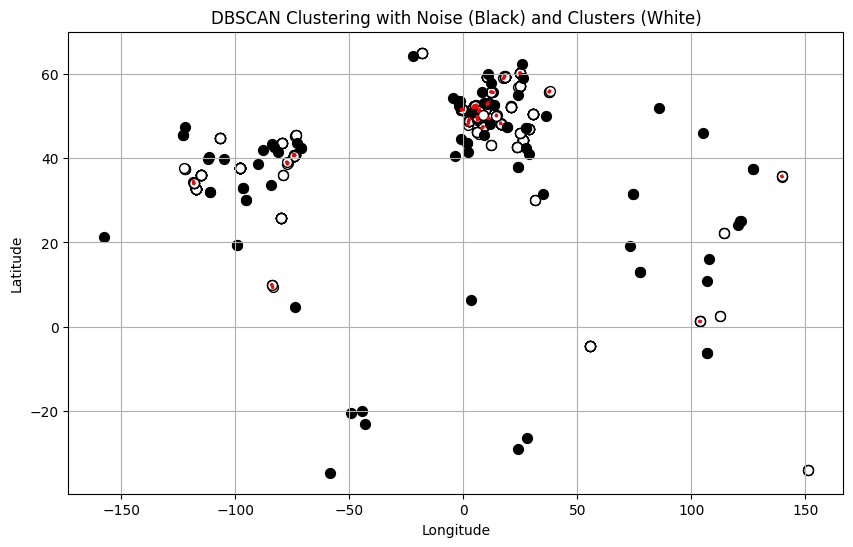

In [2]:
# %% 
import geoip2.database
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.spatial import ConvexHull, QhullError

def plot_coordinates_with_dbscan_and_hull(csv_file_path, db_path, output_csv_path, output_plot_path):
    # 1. GeoLite2データベースを読み込む
    reader = geoip2.database.Reader(db_path)

    # 2. IPアドレスリストをCSVから読み込む
    data = pd.read_csv(csv_file_path, header=None, names=['ip_address', 'value'])

    # 3. 緯度・経度を取得し、リストに保存する
    locations = []
    output_data = []  # IPアドレス、緯度、経度を保存するリスト
    for ip in data['ip_address']:
        try:
            response = reader.city(ip)
            lat = response.location.latitude
            lon = response.location.longitude
            if lat and lon:
                locations.append([lat, lon])
                # IPアドレス、緯度、経度をリストに追加
                output_data.append([ip, lat, lon])
        except geoip2.errors.AddressNotFoundError:
            pass  # 位置情報が見つからない場合は無視
        except Exception as e:
            print(f"Error retrieving data for IP: {ip} - {e}")

    # データベースを閉じる
    reader.close()

    # 4. データをCSVファイルに保存
    df = pd.DataFrame(output_data, columns=['IP Address', 'Latitude', 'Longitude'])
    df.to_csv(output_csv_path, index=False)
    print(f"IPアドレスと緯度経度が '{output_csv_path}' に保存されました。")

    # 5. DBSCANによるクラスタリング
    coordinates = np.array(locations)
    dbscan = DBSCAN(eps=1.0, min_samples=3)  # eps と min_samples はデータによって調整が必要
    labels = dbscan.fit_predict(coordinates)

    # 6. クラスタリング結果を散布図で表示
    plt.figure(figsize=(10, 6))

    # クラスタリングの結果をプロット
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1:
            # ノイズポイントは黒
            color = 'k'
        else:
            # その他のクラスタポイントは白
            color = 'w'
        
        class_member_mask = (labels == label)
        xy = coordinates[class_member_mask]
        plt.scatter(xy[:, 1], xy[:, 0], c=color, marker='o', edgecolors='k', s=50)

        # クラスタが2つ以上の点を持つ場合、凸包を計算して描画
        if len(xy) > 2 and label != -1:
            try:
                hull = ConvexHull(xy)
                for simplex in hull.simplices:
                    plt.plot(xy[simplex, 1], xy[simplex, 0], color='r', linewidth=2)
            except QhullError as e:
                print(f"ConvexHull could not be calculated for label {label}: {e}")

    plt.title('DBSCAN Clustering with Noise (Black) and Clusters (White)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # 7. クラスタリング結果を画像ファイルとして保存
    plt.savefig(output_plot_path)
    print(f"2次元座標プロットが '{output_plot_path}' に保存されました。")

    # 8. プロットを表示
    plt.show()

# 使用例
csv_file_path = 'input_ips.csv'  # 読み込むIPアドレスのCSVファイル
db_path = 'GeoLite2-City.mmdb'   # GeoLite2-City.mmdb のファイルパス
output_csv_path = 'latlng_output.csv'  # 緯度経度を保存するCSVファイル
output_plot_path = 'coordinates_dbscan_hull_plot.png'  # 2次元座標プロットを保存する画像ファイル

plot_coordinates_with_dbscan_and_hull(csv_file_path, db_path, output_csv_path, output_plot_path)
